# Fraud detection model

## Introduction

In this notebook, I aim to build a credit card fraud detection model, using ML algorithms trained on historical Nigerian bank data and then using the model to detect future fraudulent transactions.

The main steps in this notebook are:

1. Installing custom libraries
2. Loading the data 
3. Understanding and processing the data through exploratory data analysis
4. Training a machine learning model using scikit-learn and tracking experiments using MLflow and Fabric Autologging feature
5. Saving and register the best performing machine learning model
6. Loading the machine learning model for scoring and making predictions

#### Prerequisites
- A "lakehouse" was added to this notebook, because I downloaded the dataset from an SQL server and stored the data in the lakehouse. 

## Step 1: Install custom libraries
When developing a machine learning model or doing ad-hoc data analysis, one may need to install a custom library (such as `imblearn`) for the Apache Spark session.

For this notebook, I installed the `imblearn` library, using `%pip install`.

In [4]:
# Use pip to install imblearn
%pip install imblearn

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 12, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



## Step 2: Load the data

### Dataset

This research made used of some samples of Credit/Debit Cards data from Access Bank with strict and entrusted supervision so as to protect customer’s transaction details. The data set is available on request and have undergone proper organization ethics approval processes and available freely for research purposes.

- The features in the dataset includes `AcountNumber`, `CVV`, `CardInformation`, `CustomerAge`, `Gender`, `Marital Status`, `Cards`, `CardColour`, `CardType`, `TransactionType`, `Domain`, `ATM`, `POSWEBLimit`, `CreditLimit`, `Amount`, `AverageIncomeExpendicture`, `NewBalance`, `OldBalance` 

- The column `Outcome` is the target variable and takes the value `1` for fraud and `0` otherwise.

The Credit/Debit card data set consists of 37,097 observations and 19 attributes. 

The table below shows a preview of the _creditcard.csv_ data:

In [5]:
df = spark.sql("SELECT * FROM Fraud_Detection_LakeHouse.creditcard LIMIT 5")
display(df)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 14, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 261ee20a-deaa-4d9e-8f0e-d97d013e77c0)

### SMOTE
During the course of this project I'd be applying the SMOTE approach to address the problem of imbalanced classification. Imbalanced classification happens when there are too few examples of the minority class for a model to effectively learn the decision boundary.

### Set up MLflow experiment tracking

In [6]:
# Set up MLflow for experiment tracking
import mlflow

mlflow.set_experiment("fraud_detection")
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 15, Finished, Available, Finished)

### Read raw data from the lakehouse

This code reads raw data from the lakehouse.

In [7]:
df = spark.sql("SELECT * FROM Fraud_Detection_LakeHouse.creditcard")

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 16, Finished, Available, Finished)

## Step 3: Perform exploratory data analysis

In this section, you'll begin by exploring the raw data and high-level statistics. You'll then transform the data by casting the columns into the correct types and converting from a Spark DataFrame into a pandas DataFrame for easier visualization. Finally, you explore and visualize the class distributions in the data.

### Display the raw data

1. Explore the raw data and view high-level statistics by using the `display` command. For more information, see [Notebook visualization in Microsoft Fabric](https://aka.ms/fabric/visualization).

In [8]:
display(df)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5832ce2d-2959-45e0-9245-5bb1c7361e7a)

2. Print some basic information about the dataset.

In [9]:
# Print dataset basic information
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 18, Finished, Available, Finished)

records read: 37097
Schema: 
root
 |-- AcountNumber: integer (nullable = true)
 |-- CVV: short (nullable = true)
 |-- CardInformation: integer (nullable = true)
 |-- CustomerAge: byte (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Cards: string (nullable = true)
 |-- CardColour: string (nullable = true)
 |-- CardType: string (nullable = true)
 |-- TransactionType: string (nullable = true)
 |-- Domain: string (nullable = true)
 |-- ATM: integer (nullable = true)
 |-- POSWEBLimit: integer (nullable = true)
 |-- CreditLimit: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- AverageIncomeExpendicture: integer (nullable = true)
 |-- NewBalance: integer (nullable = true)
 |-- OldBalance: integer (nullable = true)
 |-- Outcome: boolean (nullable = true)



### Transform the data

1. Cast the dataset's columns into the correct types.

In [10]:
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F
from pyspark.sql.functions import col

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 19, Finished, Available, Finished)

In [11]:
def clean_data(df):
    # Replace missing values with the mean of each column in: 'CustomerAge'
    cols = ['CustomerAge']
    imputer = Imputer(inputCols=cols, outputCols=cols, strategy='mean')
    df = imputer.fit(df).transform(df)
    # Round column 'CustomerAge' (Number of decimals: 0)
    df = df.withColumn('CustomerAge', F.round(F.col('CustomerAge'), 0))
    return df

df_clean = clean_data(df)
display(df_clean)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 20, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a4b99b96-aab0-432c-bcbe-eedbde60c3b0)

In [12]:
df_clean.describe()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 21, Finished, Available, Finished)

DataFrame[summary: string, AcountNumber: string, CVV: string, CardInformation: string, CustomerAge: string, Gender: string, Marital_Status: string, Cards: string, CardColour: string, CardType: string, TransactionType: string, Domain: string, ATM: string, POSWEBLimit: string, CreditLimit: string, Amount: string, AverageIncomeExpendicture: string, NewBalance: string, OldBalance: string]

In [13]:
df_clean.groupBy('Outcome').count().show()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 22, Finished, Available, Finished)

+-------+-----+
|Outcome|count|
+-------+-----+
|   true|27370|
|  false| 9727|
+-------+-----+



2. Convert Spark DataFrame to Pandas DataFrame for easier visualization and processing.

In [14]:
df_pd = df_clean.toPandas()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 23, Finished, Available, Finished)

### Explore the  class distribution in the dataset

1. Displaying the class distribution in the dataset.

In [15]:
# Check the distribution of the target variable
outcome_counts = df_clean.groupBy('Outcome').count().toPandas()
total_count = outcome_counts['count'].sum()

# Calculate percentages
no_frauds_percentage = round(outcome_counts.loc[outcome_counts['Outcome'] == False, 'count'].values[0] / total_count * 100, 2)
frauds_percentage = round(outcome_counts.loc[outcome_counts['Outcome'] == True, 'count'].values[0] / total_count * 100, 2)

print('No Frauds:', no_frauds_percentage, '% of the dataset')
print('Frauds:', frauds_percentage, '% of the dataset')

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 24, Finished, Available, Finished)

No Frauds: 26.22 % of the dataset
Frauds: 73.78 % of the dataset


The class distribution shows that most of the transactions are fraudulent. Therefore, data preprocessing is required before model training in order to avoid overfitting.

2. Using a plot to show the class imbalance in the dataset, by viewing the distribution of fraudulent versus nonfraudulent transactions.

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 25, Finished, Available, Finished)

Text(0.5, 1.0, 'Outcome Distributions \n (False: No Fraud || True: Fraud)')

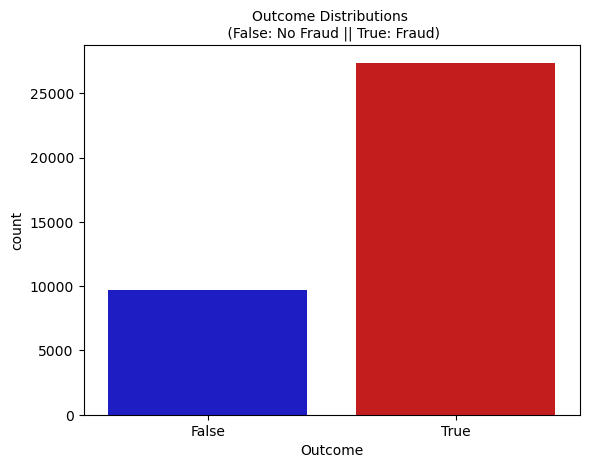

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Outcome', data=df_pd, palette=colors) 
plt.title('Outcome Distributions \n (False: No Fraud || True: Fraud)', fontsize=10)

The distribution plot clearly shows the class imbalance in the dataset.

3. Showing the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the transaction amount, using Box plots.

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 26, Finished, Available, Finished)

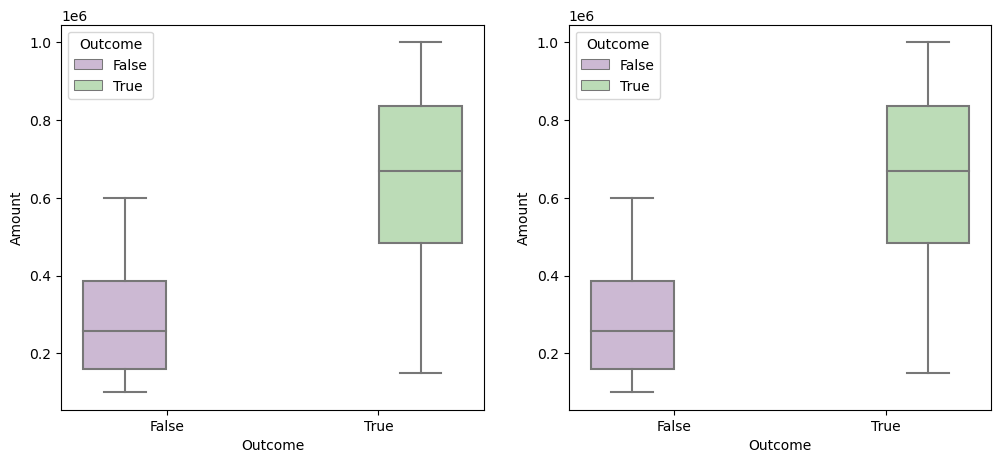

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
s1 = sns.boxplot(ax = ax1, x="Outcome", y="Amount", hue="Outcome",data=df_pd, palette="PRGn", showfliers=True) # Remove outliers from the plot
s2 = sns.boxplot(ax = ax2, x="Outcome", y="Amount", hue="Outcome",data=df_pd, palette="PRGn", showfliers=False) # Kepp outliers from the plot
plt.show()

When the data is highly imbalanced, these Box plots may not demonstrate accurate insights. Alternatively, we can address the class imbalance problem first and then create the same plots for more accurate insights.

## Step 4: Train and evaluate the model

In this section, I will train a LightGBM model to classify the fraud transactions. I'd train the LightGBM model on the imbalanced dataset and also on the balanced dataset (via SMOTE) and compare the performance of both models.

### Prepare training and test datasets

Before training, split the data into the training and test datasets.

In [18]:
import pandas as pd

def clean_dataa(df_pd):
    # One-hot encode columns: 'Gender', 'Marital_Status' and 5 other columns
    for column in ['Gender', 'Marital_Status', 'Cards', 'CardColour', 'CardType', 'TransactionType', 'Domain']:
        insert_loc = df_pd.columns.get_loc(column)
        df_pd = pd.concat([df_pd.iloc[:,:insert_loc], pd.get_dummies(df_pd.loc[:, [column]]), df_pd.iloc[:,insert_loc+1:]], axis=1)
    return df_pd

df_pd_clean = clean_dataa(df_pd.copy())
df_pd_clean.head()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 27, Finished, Available, Finished)

,AcountNumber,CVV,CardInformation,CustomerAge,Gender_Female,Gender_Male,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,...,Domain_International,Domain_Local,ATM,POSWEBLimit,CreditLimit,Amount,AverageIncomeExpendicture,NewBalance,OldBalance,Outcome
0,1250995624,437,538226,25,True,False,False,True,False,False,...,True,False,150000,2000000,500000,100639,133112,615000,514361,False
1,1244375520,607,631501,23,True,False,False,True,False,False,...,True,False,150000,2000000,500000,158407,222321,706586,548179,False
2,1280517390,504,545851,20,True,False,False,True,False,False,...,True,False,150000,2000000,500000,117844,194841,574616,456772,False
3,1250871191,424,680361,26,True,False,False,True,False,False,...,True,False,150000,2000000,500000,298143,253872,411943,113800,False
4,1272348155,676,771660,24,True,False,False,True,False,False,...,True,False,150000,2000000,500000,437227,144443,667092,229865,False


In [19]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_pd_clean, test_size=0.20)
feature_cols = [c for c in df_pd_clean.columns.tolist() if c not in ["Outcome"]]


StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 28, Finished, Available, Finished)

### Applying SMOTE to the training data to synthesize new samples for the minority class

In [20]:
# Apply SMOTE to the training data
from collections import Counter
from imblearn.over_sampling import SMOTE

X = train[feature_cols]
y = train["Outcome"]
print("Original dataset shape %s" % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("Resampled dataset shape %s" % Counter(y_res))

new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 29, Finished, Available, Finished)

Original dataset shape Counter({True: 21860, False: 7817})
Resampled dataset shape Counter({True: 21860, False: 21860})


### Training machine learning models and running experiments

1. Updating the MLflow autologging configuration to track additional metrics, parameters, and files, by setting `exclusive=False`.

In [21]:
mlflow.autolog(exclusive=False)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 30, Finished, Available, Finished)

2024/07/26 14:52:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/26 14:53:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/07/26 14:53:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


2. Training two models using **LightGBM**: one model on the imbalanced dataset and the other on the balanced (via SMOTE) dataset. Then we'd compare the performance of the two models.

In [22]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective="binary") # imbalanced dataset
smote_model = lgb.LGBMClassifier(objective="binary") # balanced dataset

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 31, Finished, Available, Finished)

2024/07/26 14:53:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


In [23]:
# Train LightGBM for both imbalanced and balanced datasets and define the evaluation metrics
print("Start training with imbalanced data:\n")
with mlflow.start_run(run_name="raw_data") as raw_run:
    model = model.fit(
        train[feature_cols],
        train["Outcome"],
        eval_set=[(test[feature_cols], test["Outcome"])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

print(f"\n\nStart training with balanced data:\n")
with mlflow.start_run(run_name="smote_data") as smote_run:
    smote_model = smote_model.fit(
        new_train[feature_cols],
        new_train["Outcome"],
        eval_set=[(test[feature_cols], test["Outcome"])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 32, Finished, Available, Finished)

Start training with imbalanced data:

[LightGBM] [Info] Number of positive: 21860, number of negative: 7817
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 29677, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.736597 -> initscore=1.028358
[LightGBM] [Info] Start training from score 1.028358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

2024/07/26 14:53:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/26 14:53:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trus



Start training with balanced data:

[LightGBM] [Info] Number of positive: 21860, number of negative: 21860
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1976
[LightGBM] [Info] Number of data points in the train set: 43720, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

2024/07/26 14:53:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/26 14:53:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trus

### Determine feature importance for training

Determining the feature importance for the model trained on the imbalanced dataset.

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 33, Finished, Available, Finished)

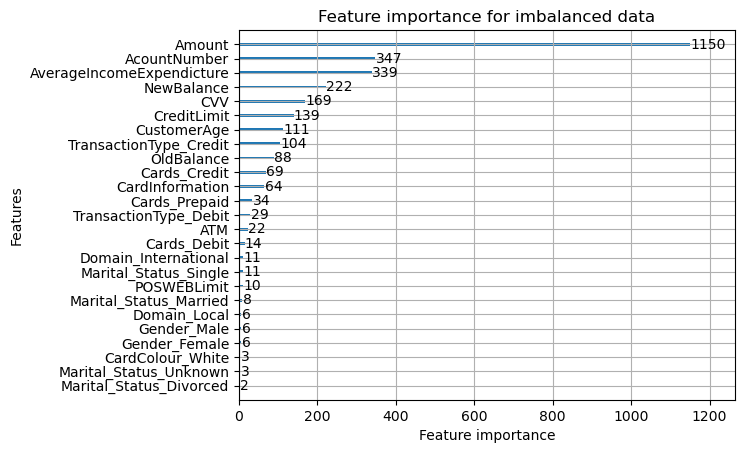

In [24]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    importance = lgb.plot_importance(
        model, title="Feature importance for imbalanced data"
    )
    importance.figure.savefig("feauture_importance.png")
    mlflow.log_figure(importance.figure, "feature_importance.png")

Determining feature importance for the model you trained on balanced (via SMOTE) dataset.

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 34, Finished, Available, Finished)

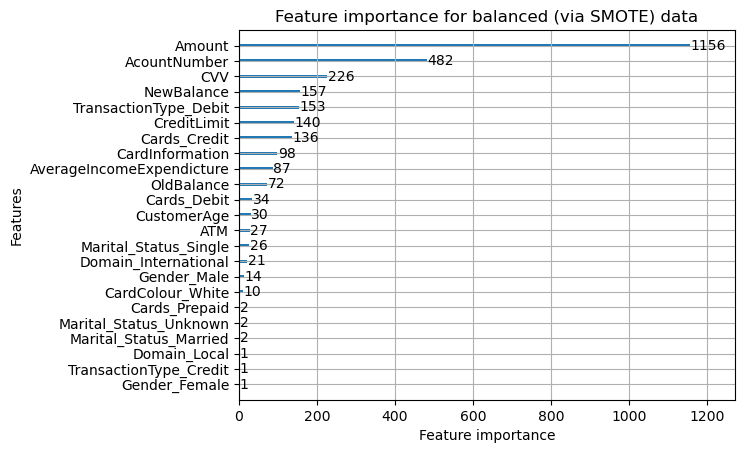

In [25]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    smote_importance = lgb.plot_importance(
        smote_model, title="Feature importance for balanced (via SMOTE) data"
    )
    smote_importance.figure.savefig("feauture_importance_smote.png")
    mlflow.log_figure(smote_importance.figure, "feauture_importance_smote.png")

A comparison of the feature importance plots shows that the important features are drastically different when you train a model with the imbalanced dataset versus the balanced dataset.

### Evaluate the models

In this section, I'd evaluate the two trained models:

- `model` trained on raw, __imbalanced data__
- `smote_model` trained on __balanced data__

#### Compute model metrics

1. First defining the function `prediction_to_spark` that performs predictions and converts the prediction results into a Spark DataFrame.

In [26]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

def prediction_to_spark(model, test):
    predictions = model.predict(test[feature_cols], num_iteration=model.best_iteration_)
    predictions = tuple(zip(test["Outcome"].tolist(), predictions.tolist()))
    dataColumns = ["Outcome", "prediction"]
    predictions = (
        spark.createDataFrame(data=predictions, schema=dataColumns)
        .withColumn("Outcome", col("Outcome").cast(IntegerType()))
        .withColumn("prediction", col("prediction").cast(DoubleType()))
    )

    return predictions

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 35, Finished, Available, Finished)

2. Using the `prediction_to_spark` function to perform predictions with the two models `model` and `smote_model`.


In [27]:
predictions = prediction_to_spark(model, test)
smote_predictions = prediction_to_spark(smote_model, test)
predictions.limit(10).toPandas()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 36, Finished, Available, Finished)

2024/07/26 14:53:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-07-26:14:53:29,677 WARNING  [tracking_store.py:153] log_inputs not supported
2024/07/26 14:53:29 WARNING mlf

,Outcome,prediction
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0
5,1,1.0
6,1,1.0
7,0,0.0
8,1,1.0
9,0,0.0


In [28]:
smote_predictions.limit(10).toPandas()

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 37, Finished, Available, Finished)

,Outcome,prediction
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0
5,1,1.0
6,1,1.0
7,0,0.0
8,1,1.0
9,0,0.0


3. Computing metrics for the two models.

In [29]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol="Outcome", scoredLabelsCol="prediction"
).transform(predictions)

smote_metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol="Outcome", scoredLabelsCol="prediction"
).transform(smote_predictions)
display(metrics)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 38, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7fcc456a-dc65-4d24-baf6-e1b32a5322f2)

In [30]:
display(smote_metrics)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 39, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, cb95026c-ed76-4f11-b4c7-eaa11b2014d7)

#### Evaluate model performance with a confusion matrix

1. Using a confusion matrix to summarize the performances of the trained machine learning models on the test data. 

In [31]:
# Collect confusion matrix value
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
smote_cm = smote_metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 40, Finished, Available, Finished)

[[1.904e+03 6.000e+00]
 [2.000e+00 5.508e+03]]


In [32]:
print(smote_cm)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 41, Finished, Available, Finished)

[[1.907e+03 3.000e+00]
 [1.000e+00 5.509e+03]]


2. Plotting the confusion matrix for the predictions of `smote_model` (trained on __balanced data__).

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 42, Finished, Available, Finished)

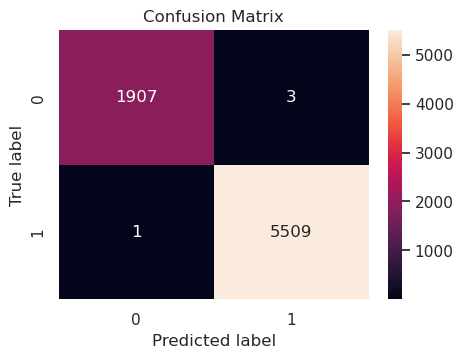

In [33]:
# Plot Confusion Matrix
import seaborn as sns

def plot(cm):
    """
    Plot the confusion matrix.
    """
    sns.set(rc={"figure.figsize": (5, 3.5)})
    ax = sns.heatmap(cm, annot=True, fmt=".20g")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

with mlflow.start_run(run_id=smote_run.info.run_id):
    ax = plot(smote_cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

3. Plotting the confusion matrix for the predictions of `model` (trained on raw, __imbalanced data__).

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 43, Finished, Available, Finished)

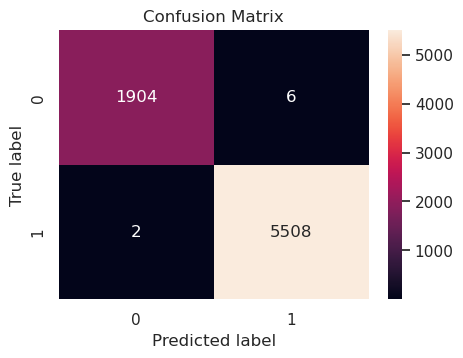

In [34]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    ax = plot(cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

#### Evaluate model performance with AUC-ROC and AUPRC measures

1. Defining a function that returns the AUC-ROC and AUPRC measures.

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """

    # Initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Outcome")

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # Calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"The AUROC is: {auroc:.4f}")

    # Calculate AUPRC, baseline positive rate (0.172% in the data)
    auprc = _evaluator("areaUnderPR")
    print(f"The AUPRC is: {auprc:.4f}")

    return auroc, auprc


StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 44, Finished, Available, Finished)

2. Logging the AUC-ROC and AUPRC metrics for the model trained on __imbalanced data__.

In [36]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    auroc, auprc = evaluate(predictions)
    mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
    mlflow.log_params({"Data_Enhancement": "None", "DATA_FILE": "creditcard.csv"})

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 45, Finished, Available, Finished)

The AUROC is: 0.9982
The AUPRC is: 0.9989


3. Logging the AUC-ROC and AUPRC metrics for the model trained on __balanced data__.

In [37]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    auroc, auprc = evaluate(smote_predictions)
    mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
    mlflow.log_params({"Data_Enhancement": "SMOTE", "DATA_FILE": "creditcard.csv"})

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 46, Finished, Available, Finished)

The AUROC is: 0.9991
The AUPRC is: 0.9994


The model trained on balanced data returns slightly higher AUC-ROC and AUPRC values compared to the model trained on imbalanced data. Based on these measures, SMOTE appears to be an effective technique for enhancing model performance when working with imbalanced data.

## Step 5: Register the models

Using MLflow to register the two models.

In [38]:
# Register the model
registered_model_name = "fraud_detection-lightgbm"

raw_model_uri = "runs:/{}/model".format(raw_run.info.run_id)
mlflow.register_model(raw_model_uri, registered_model_name)

smote_model_uri = "runs:/{}/model".format(smote_run.info.run_id)
mlflow.register_model(smote_model_uri, registered_model_name)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 47, Finished, Available, Finished)

Successfully registered model 'fraud_detection-lightgbm'.
2024/07/26 14:54:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: fraud_detection-lightgbm, version 1
Created version '1' of model 'fraud_detection-lightgbm'.
Registered model 'fraud_detection-lightgbm' already exists. Creating a new version of this model...
2024/07/26 14:54:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: fraud_detection-lightgbm, version 2
Created version '2' of model 'fraud_detection-lightgbm'.


<ModelVersion: aliases=[], creation_timestamp=1722005649449, current_stage='None', description='', last_updated_timestamp=1722005649449, name='fraud_detection-lightgbm', run_id='27e11486-b0a0-413a-a8db-88195f89c043', run_link='', source='abfss://d4e26e1b-ef05-4978-ab7e-a3116b01c483@olsch479nezolffh307s8.dfs.core.windows.net/5105fdfd-2e3d-443e-95cc-8782cd8c802e/007fed92-8d8d-4cd7-ba6d-7f71f91faec9/artifacts', status='READY', status_message='', tags={}, user_id='', version='2'>

## Step 6: Save the prediction results

1. Loading the better-performing model for batch scoring and generating the prediction results.

In [40]:
from synapse.ml.predict import MLFlowTransformer

spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=feature_cols,
    outputCol="prediction",
    modelName="fraud_detection-lightgbm",
    modelVersion=2,
)

test_spark = spark.createDataFrame(data=test, schema=test.columns.to_list())

batch_predictions = model.transform(test_spark)

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 49, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 50, Finished, Available, Finished)

2. Save predictions into the lakehouse.

In [41]:
# Save the predictions into the lakehouse
batch_predictions.write.format("delta").mode("overwrite").save("Files/fraud-detection/predictions/batch_predictions")

StatementMeta(, c767b7d6-0f00-44ef-9b27-6224d9c97672, 51, Finished, Available, Finished)